In [1]:
import os
from glob import glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch, gc

# Load data and preprocess

In [2]:
# Create Dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')
    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))
    df = pd.DataFrame(data= {'images': images_paths, 'masks': masks_paths})
    return df

data_dir = '../data/kaggle_3m'
df = create_df(data_dir)
df.head()

,images,masks
0,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...
1,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...
2,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...
3,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...
4,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...


In [3]:
# # Function to display images and masks
# def show_images(images, masks):
#     plt.figure(figsize=(12, 12))
#     for i in range(25):
#         plt.subplot(5, 5, i + 1)

#         img_path = images[i]
#         mask_path = masks[i]

#         # Read and convert image to RGB
#         image = cv.imread(img_path)
#         image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

#         # Read the mask
#         mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE) 

#         # Display the image
#         plt.imshow(image)
#         plt.imshow(mask, cmap="jet", alpha=0.4) 
#         plt.axis("off")

#     plt.tight_layout()
#     plt.show()

# show_images(list(df["images"]), list(df["masks"]))

In [4]:
class MaskBinarize:
    def __call__(self, msk):
        msk = (msk > 0.5).float()  
        return msk
    
def img_to_tensor(df, mask=False):#, image_size=(224, 224)):
    if mask:
        transform = transforms.Compose([
            #transforms.Resize(image_size),  
            transforms.ToTensor(),          
            MaskBinarize()
        ])
    else:
        transform = transforms.Compose([
            #transforms.Resize(image_size),  
            transforms.ToTensor(),          
            #MaskBinarize()
        ])
    
    image_tensors = []
    
    for img_path in df:
        try:
            if mask:
                img = Image.open(img_path).convert("L")  # grayscale transform
                img_tensor = transform(img)  # to tensor
                image_tensors.append(img_tensor)
            else:
                img = Image.open(img_path).convert("RGB")  # RGB transform
                img_tensor = transform(img)  # to tensor
                image_tensors.append(img_tensor)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if image_tensors:
        # (batch, C, H, W)
        image_tensors = torch.stack(image_tensors)
        print(f"Loaded {len(image_tensors)} images successfully.")
        return image_tensors
    else:
        print("No valid images were loaded.")
        return None

image_tensors = img_to_tensor(df["images"])
mask_tensors = img_to_tensor(df["masks"], mask=True)

if image_tensors is not None:
    print(f"Final tensor shape: {image_tensors.shape}")  # (N, C, H, W)


Loaded 3929 images successfully.
Loaded 3929 images successfully.
Final tensor shape: torch.Size([3929, 3, 256, 256])


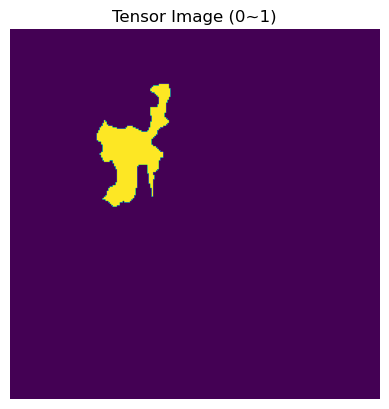

In [5]:
np_img = mask_tensors[6].permute(1, 2, 0).numpy()  # shape: [H, W, 3]

# print test
plt.imshow(np_img)
plt.axis('off')
plt.title("Tensor Image (0~1)")
plt.show()

In [6]:
# data split: 80/10/10
train_img, test_img, train_mask, test_mask = train_test_split(image_tensors, mask_tensors, test_size = 0.1)
train_img, val_img, train_mask, val_mask = train_test_split(train_img, train_mask, test_size = 0.1)

In [7]:
train_dataset = TensorDataset(train_img, train_mask)
val_dataset = TensorDataset(val_img, val_mask)
test_dataset = TensorDataset(test_img, test_mask)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Model design

In [8]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu, sigmoid
from datetime import datetime

In [9]:
folder_path = './models'

kernel_size = 3
stride = 1
padding = 1

num_epochs = 200
patience = 50

bce_weight = 0.5 # Coefficient for Binary Cross Entropy loss in loss function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
class UNet(nn.Module):
    def __init__(self, kernel_size, stride, padding):
        super().__init__()

        # Encoder - Downsample input images using max-pooling (256x256x3 images)
        self.e11 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e12 = nn.Conv2d(32, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e22 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e32 = nn.Conv2d(128, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e42 = nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(256, 512, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e52 = nn.Conv2d(512, 512, kernel_size=kernel_size, stride=stride, padding=padding)


        # Decoder - Upsampling using transposed convolution
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(512, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d12 = nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d22 = nn.Conv2d(128, 128, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d32 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(64, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d42 = nn.Conv2d(32, 32, kernel_size=kernel_size, stride=stride, padding=padding)


        # Output
        self.output = nn.Conv2d(32, 1, kernel_size=1)


    # Input processing through the model
    def forward(self, x):
        # Encoder
        e11 = relu(self.e11(x))
        e12 = relu(self.e12(e11))
        maxpool1 = self.maxpool1(e12)

        e21 = relu(self.e21(maxpool1))
        e22 = relu(self.e22(e21))
        maxpool2 = self.maxpool2(e22)

        e31 = relu(self.e31(maxpool2))
        e32 = relu(self.e32(e31))
        maxpool3 = self.maxpool3(e32)

        e41 = relu(self.e41(maxpool3))
        e42 = relu(self.e42(e41))
        maxpool4 = self.maxpool4(e42)

        e51 = relu(self.e51(maxpool4))
        e52 = relu(self.e52(e51))

        # Decoder
        upconv1 = self.upconv1(e52)
        upconv1 = torch.cat([upconv1, e42], dim=1)
        d11 = self.d11(upconv1)
        d12 = self.d12(d11)

        upconv2 = self.upconv2(e42)
        upconv2 = torch.cat([upconv2, e32], dim=1)
        d21 = self.d21(upconv2)
        d22 = self.d22(d21)

        upconv3 = self.upconv3(d22)
        upconv3 = torch.cat([upconv3, e22], dim=1)
        d31 = self.d31(upconv3)
        d32 = self.d32(d31)

        upconv4 = self.upconv4(d32)
        upconv4 = torch.cat([upconv4, e12], dim=1)
        d41 = self.d41(upconv4)
        d42 = self.d42(d41)

        out = self.output(d42)
        out = sigmoid(out)

        return out

In [11]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, true):
        pred = pred.view(-1)
        true = true.view(-1)
        intersection = (pred*true).sum()
        dice = (2*intersection + self.smooth) / (pred.sum() + true.sum() + self.smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, pred, true):
        bce_loss = self.bce(pred, true)
        dice_loss = self.dice(pred, true)
        return bce_weight * bce_loss + (1-bce_weight) * dice_loss
        

In [12]:
model = UNet(kernel_size, stride, padding)
model.to(device)

UNet(
  (e11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(256, 512, kernel

In [13]:
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_model_filename = None
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss(bce_weight=0.5)


for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in trainloader:
        optimizer.zero_grad(set_to_none=True)
        images, true_mask = batch
        images = images.to(device)
        true_mask = true_mask.to(device)

        pred_mask = model(images)

        loss = 0
        loss += criterion(pred_mask, true_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(trainloader)


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in valloader:
            optimizer.zero_grad(set_to_none=True)
            images, true_mask = batch
            images = images.to(device)
            true_mask = true_mask.to(device)

            pred_mask = model(images)

            loss = 0
            loss += criterion(pred_mask, true_mask)
            val_loss += loss.item()
        
    avg_val_loss = val_loss / len(valloader)
    
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

    # Best model saving & early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() 
        best_model_filename = f"{folder_path}/best_model_{str(best_val_loss)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        print("Validation loss improved. Best model updated.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

        
            

Epoch 1/200 - Train Loss: 0.6611 - Validation Loss: 0.5313
Validation loss improved. Best model updated.
Epoch 2/200 - Train Loss: 0.5176 - Validation Loss: 0.4813
Validation loss improved. Best model updated.
Epoch 3/200 - Train Loss: 0.4269 - Validation Loss: 0.3177
Validation loss improved. Best model updated.
Epoch 4/200 - Train Loss: 0.3132 - Validation Loss: 0.2455
Validation loss improved. Best model updated.
Epoch 5/200 - Train Loss: 0.2854 - Validation Loss: 0.2410
Validation loss improved. Best model updated.
Epoch 6/200 - Train Loss: 0.2669 - Validation Loss: 0.2173
Validation loss improved. Best model updated.
Epoch 7/200 - Train Loss: 0.2644 - Validation Loss: 0.2098
Validation loss improved. Best model updated.
Epoch 8/200 - Train Loss: 0.2614 - Validation Loss: 0.2108
No improvement for 1 epoch(s).
Epoch 9/200 - Train Loss: 0.2391 - Validation Loss: 0.2246
No improvement for 2 epoch(s).
Epoch 10/200 - Train Loss: 0.2403 - Validation Loss: 0.2078
Validation loss improved.

In [14]:
# save the best model
if best_model_state is not None:
    torch.save(best_model_state, best_model_filename)
    print(f"Best model saved to {best_model_filename}")

Best model saved to ./models/best_model_0.06858640909194946_20250420_121526.pth


In [15]:
model.load_state_dict(torch.load(best_model_filename, map_location=device))
model.eval()

pred_mask_all, true_mask_all = [], []

with torch.no_grad():
    for batch in testloader:
        images, true_mask = batch
        images = images.to(device)
        true_mask = true_mask.to(device)

        pred_mask = model(images)

        pred_mask_all.append(pred_mask.cpu().numpy())
        true_mask_all.append(true_mask.cpu().numpy())
                             
    preds = np.concatenate(pred_mask_all, axis=0)   # shape: (N, H, W) or (N, 1, H, W)
    trues = np.concatenate(true_mask_all, axis=0)        

    if preds.ndim == 4 and preds.shape[1] == 1:
        preds = preds.squeeze(1)
        trues = trues.squeeze(1)

    preds  = (preds > 0.5).astype(np.uint8)
    trues  = trues.astype(np.uint8)

    preds = preds.flatten()
    trues = trues.flatten()

    tp = np.logical_and(preds==1, trues==1).sum()
    fp = np.logical_and(preds==1, trues==0).sum()
    fn = np.logical_and(preds==0, trues==1).sum()

    smooth = 1e-6
    dice = (2*tp + smooth) / (2*tp + fp + fn + smooth)
    iou  = (tp + smooth)   / (tp + fp + fn + smooth)
    recall = tp / (tp + fn + smooth)

                             
    # Dice coefficient
    # IoU (Jaccard Index)
    # Recall - We care a lot about false negatives
    metrics = {
        'Dice Coefficient': dice,
        'IoU': iou,
        'Recall': recall
        }
    
    print("\n **Test Results:**")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")



 **Test Results:**
Dice Coefficient: 0.8907
IoU: 0.8029
Recall: 0.9007


In [16]:
def show_images(images: torch.Tensor,
                masks: torch.Tensor,
                n_images: int = 25):
    """
    images: torch.Tensor of shape (N, C, H, W) or (N, H, W, C), values in [0,1] or [0,255]
    masks:  torch.Tensor of shape (N, 1, H, W) or (N, H, W), values 0/1 or 0~255
    n_images: number of samples to show (<= N), default is 25
    """

    n = min(n_images, images.shape[0], masks.shape[0])

    plt.figure(figsize=(12, 12))
    for i in range(n):
        # image tensor to numpy
        img = images[i]
        if img.dim() == 3 and img.shape[0] in (1,3):  
            # (C, H, W) → (H, W, C)
            img = img.permute(1, 2, 0)
        img_np = img.detach().cpu().numpy()

        # set to range [0,1]
        if img_np.max() > 1.0:
            img_np = img_np / 255.0

        # mask tensor to numpy
        m = masks[i]
        if m.dim() == 3 and m.shape[0] == 1:  
            m = m.squeeze(0)  # (1, H, W) → (H, W)
        mask_np = m.detach().cpu().numpy()

        # set to range [0,1]
        if mask_np.max() > 1.0:
            mask_np = mask_np / mask_np.max()

        # print
        ax = plt.subplot(5, 5, i + 1)
        ax.imshow(img_np)
        ax.imshow(mask_np, cmap='jet', alpha=0.4)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

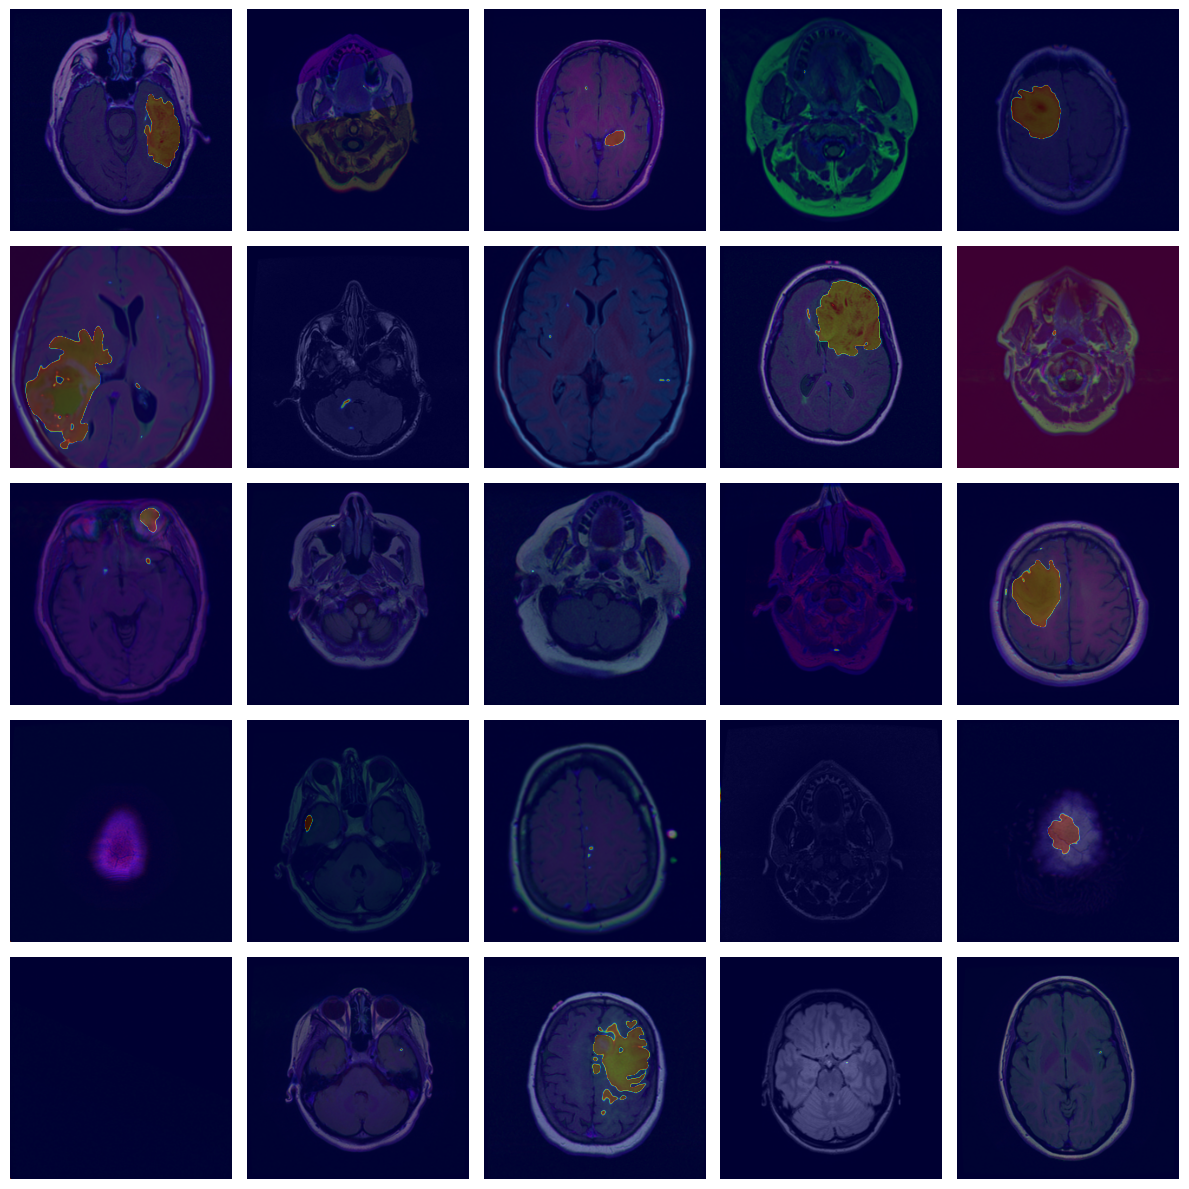

In [17]:
test_batch, true_mask_batch = next(iter(testloader))
test_batch = test_batch.to(device)
pred_mask = model(test_batch)
show_images(test_batch, pred_mask)

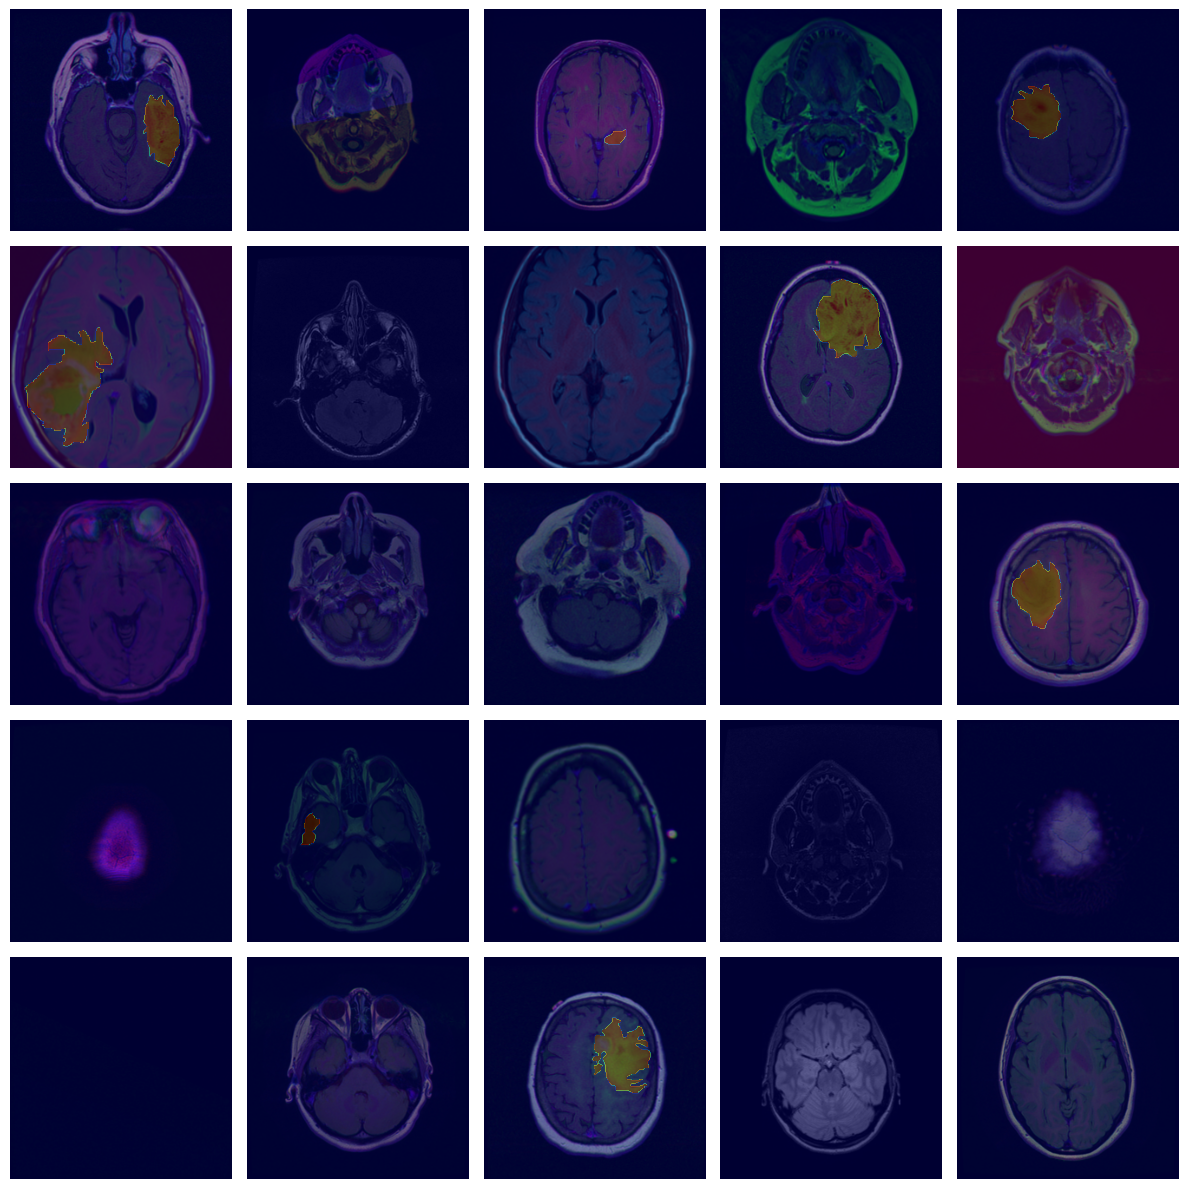

In [18]:
show_images(test_batch, true_mask_batch)